# Velocity Analysis with scVelo

In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import scanpy as sc
import os
import re

I'll be analyzing the loom files created in child_qmds/velocity_analysis.qmd using scVelo.

First I'm going to define a function that will take all loom files for a given dataset and merge them into a single anndata object. This function will add metadata to the anndata objects as well.

In [2]:
def loom_to_an(loom_path, metadata_path):
    loom_files=os.listdir(loom_path)
    #initialize list to hold anndata objects
    ad_obs = []
    for one_loom in loom_files:
        #get sample id from file name
        sample_id = re.sub(".loom", "", one_loom)
        #add object to list
        tmp = anndata.read_loom(loom_path + "/" + one_loom)
        #read in metadata file
        md_path = metadata_path + "/" + sample_id + "_metadata.csv"
        metadata = pd.read_csv(md_path, index_col = "bc")
        tmp.obs = metadata.filter(regex = '^(?!umap_|PC_|fdl_|harmony_).*$').reindex(tmp.obs.index)
        #Add pca embeddings
        tmp.obsm["X_pca"] = metadata.filter(regex = "PC_").reindex(tmp.obs.index).to_numpy()
        #Add umap embeddings
        tmp.obsm["X_umap"] = metadata.filter(regex = "umap_").reindex(tmp.obs.index).to_numpy()
        #add fdl embeddings
        tmp.obsm["X_fdl"] = metadata.filter(regex = "fdl_").reindex(tmp.obs.index).to_numpy()
        #add harmony embeddings
        tmp.obsm["X_harmony"] = metadata.filter(regex = "harmony_").reindex(tmp.obs.index).to_numpy ()
        #make var names unique (this step is necessary to merge anndata list)
        tmp.var_names_make_unique()
        #add object to list
        ad_obs.append(tmp)
    #merge anndata list
    merged_anndata = anndata.concat(ad_obs)
    #return merged anndata
    return merged_anndata


def calc_velo(ad_ob, mode = "stochastic", group = "seurat_clusters"):
    sc.pp.neighbors(ad_ob, n_pcs = 30, n_neighbors = 30)
    scv.pp.moments(ad_ob)
    scv.tl.velocity(ad_ob, mode = mode)

def make_plots(ad_ob):
    scv.tl.velocity_graph(ad_ob, backend = "threading")
    scv.pl.velocity_embedding_stream(ad_ob, basis = "umap", color = "seurat_clusters")
    scv.pl.velocity_embedding(ad_ob, basis = "umap", color = "seurat_clusters")
    # scv.pl.velocity_embedding_stream(ad_ob, basis = "umap", color = "Phase")
    # scv.pl.velocity_embedding_stream(ad_ob, basis = "fdl", color = "seurat_clusters")



In [ ]:
# loom_path = "loom_output/patient_mets_cancer_cells/loom_files"
# metadata_path = "loom_output/patient_mets_cancer_cells/metadata"
# one_loom = "CCDI0094_7977.loom"
# sample_id = "CCDI0094_7977"
# tmp = anndata.read_loom(loom_path + "/" + one_loom)
# #read in metadata file
# md_path = metadata_path + "/" + sample_id + "_metadata.csv"
# metadata = pd.read_csv(md_path)
# if len(metadata) == 1:
#     uni_bc = metadata["bc"]
#     metadata["bc"] = uni_bc.replace("x", "-1")
# uni_bc.replace("x", "-1")

## Cancer Cells

This section will examine the cancer cells from our datasets.

### mm_mets_cancer_cells

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)
or disable the progress bar using `show_progress_bar=False`.


/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2721983) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future versio

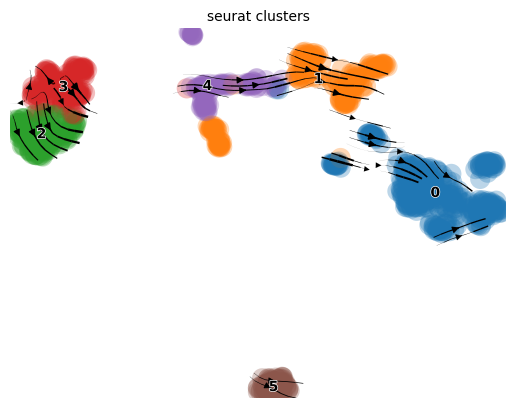

/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfs0/home2/gdrobertslab/mjg015/R/x86_64-pc-linux-gnu-library/4.3/rrrSingleCellUtils/r_rna_velo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future versio

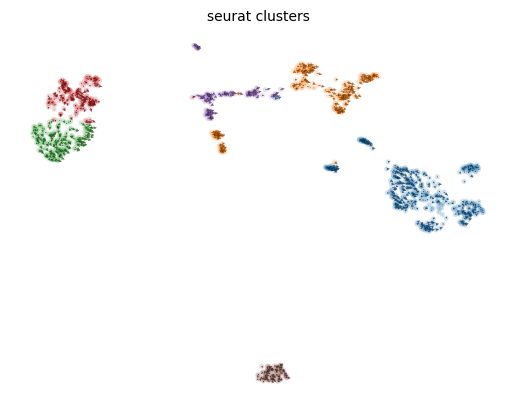

In [3]:
mm_mets_cancer_cells = loom_to_an(loom_path = "loom_output/mm_mets_cancer_cells/loom_files",
                metadata_path = "loom_output/mm_mets_cancer_cells/metadata")

calc_velo(mm_mets_cancer_cells)

make_plots(mm_mets_cancer_cells)

### mm_prim_cancer_cells

In [4]:
mm_prim_cancer_cells =loom_to_an(loom_path="loom_output/mm_prim_cancer_cells/loom_files",
               metadata_path="loom_output/mm_prim_cancer_cells/metadata")

calc_velo(mm_prim_cancer_cells)

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


: 

In [ ]:
make_plots(mm_prim_cancer_cells)

### patient_mets_cancer_cells

In [ ]:
patient_mets_cancer_cells = loom_to_an(loom_path= "loom_output/patient_mets_cancer_cells/loom_files",
                metadata_path = "loom_output/patient_mets_cancer_cells/metadata")

calc_velo(patient_mets_cancer_cells)

In [ ]:
make_plots(patient_mets_cancer_cells)

### patient_prim_cancer_cells

In [ ]:
patient_prim_cancer_cells = loom_to_an(loom_path = "loom_output/patient_prim_cancer_cells/loom_files",
                metadata_path="loom_output/patient_prim_cancer_cells/metadata")

calc_velo(patient_prim_cancer_cells)

In [ ]:
make_plots(patient_prim_cancer_cells)

### xeno_prim_human

## Patient Mets Macrophages